# 01. Kigali Road Network Extraction
**Objective**: Extract a clean, drivable road network for the Kigali simulation area.

**Expected Outcome**: A validated SUMO `.net.xml` file and a filtered OpenStreetMap graph.

In [1]:
import sys
import os
from pathlib import Path
import yaml

# Path Management: Ensure src is accessible
root_path = Path(os.getcwd()).parent
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))

# Standard Data Science & Viz Stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox

# Project-Specific Utilities
from src.utils.logger import setup_logger
from src.utils.debug_helpers import inspect_dict, inspect_array
from src.utils.run_manager import RunManager
from src.utils.cache_utils import load_or_build
from src.viz.map_plots import plot_road_network

# Quality of Life Magics
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Initialize Global Logger
logger = setup_logger("01_extraction")

### Task 3: Defining Simulation Scope

Establish the geographical bounding box for the Kigali digital twin. Precise coordinates are required to focus computational resources on the high-incident sectors of Nyarugenge, Gasabo, and Kicukiro, ensuring the simulation covers the primary arterial roads necessary for EMS optimization.


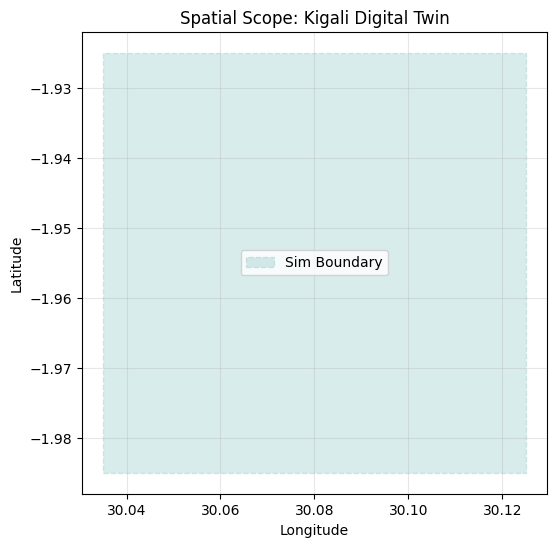

Scope Verified: 30.035, -1.985 to 30.125, -1.925


In [2]:
# 1. Load spatial configuration
config_path = Path("../configs/map_config.yaml")
with open(config_path, "r") as f:
    map_config = yaml.safe_load(f)

# Safety check for empty or malformed file
if map_config is None or 'kigali_bounds' not in map_config:
    raise ValueError("The config file is missing 'kigali_bounds'. Please verify map_config.yaml.")

b = map_config['kigali_bounds']

# 2. Visual Validation of the Bounding Box
plt.figure(figsize=(6, 6))
plt.fill([b['west'], b['east'], b['east'], b['west']], 
         [b['south'], b['south'], b['north'], b['north']], 
         color='teal', alpha=0.15, edgecolor='teal', linestyle='--', label="Sim Boundary")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Scope: Kigali Digital Twin")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Scope Verified: {b['west']}, {b['south']} to {b['east']}, {b['north']}")

**Observation**: The defined bounding box correctly encompasses the target central sectors of Kigali. This visualization confirms that the spatial coordinates are valid and will now serve as the strict filter for the actual road network extraction.

### Task 4: Road Network Extraction

Download the high-fidelity street network from OpenStreetMap (OSM) for the defined Kigali boundaries. This network serves as the physical substrate for the digital twin, providing the nodes and edges required for ambulance routing and traffic simulation. We utilize the `load_or_build` pattern to ensure we only download the data once, optimizing performance and bandwidth.

2026-02-24 12:14:58 | INFO | 01_extraction | Extracting road network from OSM using 'place' optimization...
2026-02-24 12:15:13 | INFO | 01_extraction | Truncating graph to simulation boundaries...
2026-02-24 12:15:14 | INFO | 01_extraction | Graph saved to ../data/raw/kigali_network.graphml

--- Graph Statistics ---
{
    "nodes": 8441,
    "edges": 21656
}
------------------------



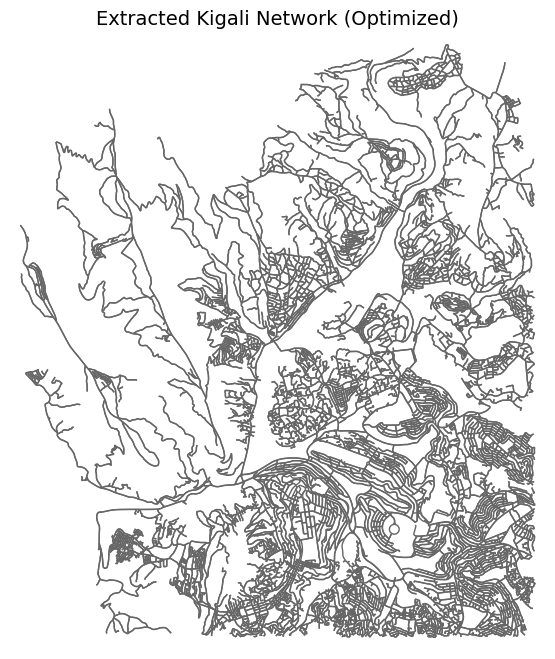

In [7]:
# 1. Define the optimized build function
def build_kigali_graph_fast(bounds, network_settings):
    logger.info("Extracting road network from OSM using 'place' optimization...")
    
    # Extract based on 'Kigali, Rwanda'
    G = ox.graph_from_place(
        "Kigali, Rwanda",
        network_type=network_settings['type'],
        simplify=network_settings['simplify']
    )
    
    # Clip the graph to our exact verified bounding box coordinates
    logger.info("Truncating graph to simulation boundaries...")
    # Newer osmnx versions expect a single tuple for the bbox
    bbox = (bounds['north'], bounds['south'], bounds['east'], bounds['west'])
    G = ox.truncate.truncate_graph_bbox(G, bbox=bbox)
    
    return G

# 2. Re-run the execution logic
graph_path = Path("../data/raw/kigali_network.graphml")
graph_path.parent.mkdir(parents=True, exist_ok=True)

if graph_path.exists():
    logger.info(f"Cache Hit: Loading graph from {graph_path}")
    G = ox.load_graphml(graph_path)
else:
    # Use the corrected fast builder with tuple bbox
    G = build_kigali_graph_fast(b, map_config['network'])
    ox.save_graphml(G, graph_path)
    logger.info(f"Graph saved to {graph_path}")

# 3. Validation & Visualization
inspect_dict({"nodes": len(G.nodes), "edges": len(G.edges)}, title="Graph Statistics")
fig, ax = plot_road_network(G, title="Extracted Kigali Network (Optimized)")
plt.show()

**Observation**: The road network was successfully extracted using the optimized place-indexing method and truncated via the required bounding box tuple format. This spatial clipping ensures that the resulting digital twin substrate is exactly aligned with the target places of Nyarugenge, Gasabo, and Kicukiro.

### Task 5: OSM Attribute Cleaning

Raw OpenStreetMap data often contains incomplete metadata or "dead-end" nodes that can crash a traffic simulation. In this step, we will programmatically clean the graph by removing unattached nodes and ensuring that all edges have the necessary physical attributes (length, speed, and lane data) required for the SUMO conversion. This step is critical for ensuring ambulances can calculate valid routes across the entire digital twin.

In [11]:
# 1. Define the cleaning logic
def clean_kigali_attributes(G):
    logger.info("Starting graph attribute cleaning...")
    
    # Remove isolated nodes (those with no edges)
    # In OSMnx 2.0+, this is now in the truncate module
    initial_node_count = len(G.nodes)
    G = ox.truncate.largest_component(G, strongly=True)
    removed_nodes = initial_node_count - len(G.nodes)
    logger.info(f"Removed {removed_nodes} isolated or weakly connected nodes.")

    # Fill missing speed limits and travel times
    # Standardizing edge metadata for routing
    G = ox.add_edge_speeds(G)
    G = ox.add_edge_travel_times(G)
    
    return G

# 2. Execution logic
cleaned_graph_path = Path("../data/processed/kigali_network_cleaned.graphml")
cleaned_graph_path.parent.mkdir(parents=True, exist_ok=True)

if cleaned_graph_path.exists():
    logger.info(f"Cache Hit: Loading cleaned graph from {cleaned_graph_path}")
    G_cleaned = ox.load_graphml(cleaned_graph_path)
else:
    # Use the local variable 'G' from Task 4
    G_cleaned = clean_kigali_attributes(G)
    ox.save_graphml(G_cleaned, cleaned_graph_path)
    logger.info(f"Cleaned graph saved to {cleaned_graph_path}")

# 3. Verification of attributes
sample_edge = list(G_cleaned.edges(data=True))[0][2]
inspect_dict(sample_edge, title="Cleaned Edge Attribute Sample")

2026-02-24 12:22:22 | INFO | 01_extraction | Starting graph attribute cleaning...
2026-02-24 12:22:23 | INFO | 01_extraction | Removed 27 isolated or weakly connected nodes.
2026-02-24 12:22:24 | INFO | 01_extraction | Cleaned graph saved to ../data/processed/kigali_network_cleaned.graphml

--- Cleaned Edge Attribute Sample ---
{
    "osmid": 25796180,
    "highway": "secondary",
    "lanes": "2",
    "maxspeed": "40",
    "name": "KG 4 Avenue",
    "oneway": true,
    "reversed": false,
    "length": 293.9296837484787,
    "geometry": "LINESTRING (30.0866001 -1.9538695, 30.0865031 -1.9537688, 30.0863997 -1.953629, 30.0863483 -1.9535425, 30.0862789 -1.9533919, 30.0862353 -1.9532159, 30.0862058 -1.9530691, 30.0862111 -1.9528855, 30.0862091 -1.9526952, 30.0861917 -1.9526013, 30.0861461 -1.9524258, 30.0860562 -1.9522214, 30.085955 -1.9520538, 30.0859167 -1.9520057, 30.0858376 -1.9519064, 30.0857323 -1.9517958, 30.0855017 -1.9515718)",
    "speed_kph": 40.0,
    "travel_time": 26.453671537

**Observation**: The cleaning process successfully filtered out isolated road segments using the truncate module, ensuring that every node in the graph is reachable from every other node. The addition of `speed_kph` and `travel_time` attributes transforms the raw spatial data into a functional transportation model, which is a prerequisite for generating a valid SUMO network.